# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
pd.set_option("display.max_rows",15)
%matplotlib inline

In [2]:
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label", "x"]

kdd_train = pd.read_csv("dataset/KDDTrain+.txt",names = col_names,)
kdd_test = pd.read_csv("dataset/KDDTest+.txt",names = col_names,)

kdd_train = kdd_train.drop("x", axis = 1)
kdd_test = kdd_test.drop("x", axis = 1)

In [3]:
category_variables = ["protocol_type","service","flag"]
for cv in category_variables:
    kdd_train[cv] = kdd_train[cv].astype("category")
    kdd_test[cv] = kdd_test[cv].astype("category", categories = kdd_train[cv].cat.categories)

In [4]:
kdd_train

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
5,0,tcp,private,REJ,0,0,0,0,0,0,...,19,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,neptune
6,0,tcp,private,S0,0,0,0,0,0,0,...,9,0.04,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125966,0,tcp,private,S0,0,0,0,0,0,0,...,13,0.05,0.07,0.00,0.00,1.00,1.00,0.00,0.00,neptune
125967,0,tcp,http,SF,359,375,0,0,0,0,...,255,1.00,0.00,0.33,0.04,0.33,0.00,0.00,0.00,normal


In [5]:
kdd_train.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,...,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,...,182.148945,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,...,99.206213,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
print("Column - Label")
print("Unique values: \n{}".format(kdd_train.label))
print("\nStatistical properties: \n{}".format(kdd_train.label.describe()))

Column - Label
Unique values: 
0          normal
1          normal
2         neptune
3          normal
4          normal
5         neptune
6         neptune
           ...   
125966    neptune
125967     normal
125968    neptune
125969     normal
125970     normal
125971    neptune
125972     normal
Name: label, dtype: object

Statistical properties: 
count     125973
unique        23
top       normal
freq       67343
Name: label, dtype: object


In [7]:
attack_types = {
    'normal': 'normal',
    
    'back': 'DoS',
    'land': 'DoS',
    'neptune': 'DoS',
    'pod': 'DoS',
    'smurf': 'DoS',
    'teardrop': 'DoS',
    'mailbomb': 'DoS',
    'apache2': 'DoS',
    'processtable': 'DoS',
    'udpstorm': 'DoS',
    
    'ipsweep': 'Probe',
    'nmap': 'Probe',
    'portsweep': 'Probe',
    'satan': 'Probe',
    'mscan': 'Probe',
    'saint': 'Probe',

    'ftp_write': 'R2L',
    'guess_passwd': 'R2L',
    'imap': 'R2L',
    'multihop': 'R2L',
    'phf': 'R2L',
    'spy': 'R2L',
    'warezclient': 'R2L',
    'warezmaster': 'R2L',
    'sendmail': 'R2L',
    'named': 'R2L',
    'snmpgetattack': 'R2L',
    'snmpguess': 'R2L',
    'xlock': 'R2L',
    'xsnoop': 'R2L',
    'worm': 'R2L',
    
    'buffer_overflow': 'U2R',
    'loadmodule': 'U2R',
    'perl': 'U2R',
    'rootkit': 'U2R',
    'httptunnel': 'U2R',
    'ps': 'U2R',    
    'sqlattack': 'U2R',
    'xterm': 'U2R'
}

is_attack = {
    "DoS":"Attack",
    "R2L":"Attack",
    "U2R":"Attack",
    "Probe":"Attack",
    "normal":"Normal"
}

In [8]:
kdd_train["attack_type"] = kdd_train.label.map(lambda x: attack_types[x])
kdd_train["is_attack"] = kdd_train.attack_type.map(lambda x: is_attack[x])

kdd_test["attack_type"] = kdd_test.label.map(lambda x: attack_types[x])
kdd_test["is_attack"] = kdd_test.attack_type.map(lambda x: is_attack[x])


In [9]:
kdd_attack_type_group = kdd_train.groupby("attack_type")
kdd_is_attack_group = kdd_train.groupby("is_attack")


In [10]:
kdd_attack_type_group.is_attack.count()

attack_type
DoS       45927
Probe     11656
R2L         995
U2R          52
normal    67343
Name: is_attack, dtype: int64

In [11]:
kdd_is_attack_group.attack_type.count()

is_attack
Attack    58630
Normal    67343
Name: attack_type, dtype: int64

In [12]:
#kdd_is_attack_group.hist(figsize=[25,22])

In [13]:
#kdd_attack_type_group.hist(figsize=[25,22])

In [14]:
dummy_variables_2labels = [*category_variables, "is_attack"]
dummy_variables_5labels = [*category_variables, "attack_type"]

drop_variables = [*category_variables, "is_attack", "attack_type", "label"]

In [15]:
kdd_train_one_hot_2labels = pd.get_dummies(kdd_train[dummy_variables_2labels], prefix=dummy_variables_2labels, drop_first=False)
kdd_train_one_hot_5labels = pd.get_dummies(kdd_train[dummy_variables_5labels], prefix=dummy_variables_5labels, drop_first=False)

kdd_train_2labels = pd.concat([kdd_train.drop(drop_variables, axis = 1)
                               , kdd_train_one_hot_2labels]
                              , axis = 1)
kdd_train_5labels = pd.concat([kdd_train.drop(drop_variables, axis = 1)
                              , kdd_train_one_hot_5labels]
                              , axis = 1)


kdd_test_2labels = pd.get_dummies(kdd_test, columns = dummy_variables_2labels, prefix=dummy_variables_2labels, drop_first=False)
kdd_test_2labels = kdd_test_2labels.drop(["attack_type", "label"], axis = 1)

In [16]:
kdd_train_2labels

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,is_attack_Attack,is_attack_Normal
0,0,491,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,0,146,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,0,232,8153,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
4,0,199,420,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125966,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
125967,0,359,375,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1


In [17]:
kdd_train_5labels

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,attack_type_DoS,attack_type_Probe,attack_type_R2L,attack_type_U2R,attack_type_normal
0,0,491,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0,146,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,232,8153,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
4,0,199,420,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125966,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
125967,0,359,375,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1


In [18]:
import tensorflow as tf

sess = tf.InteractiveSession()

In [19]:
tf.reset_default_graph()

input_dim = 122
classes = 2
hidden_encoder_dim = 40

latent_dim = 10

hidden_decoder_dim = 40

lam = 0.01

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.001)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.01, shape=shape)
    return tf.Variable(initial)

l2_loss = tf.constant(0.001)
#learning_rate = tf.Variable(initial_value=0.001)

with tf.variable_scope("Input"):
    x = tf.placeholder("float", shape=[None, input_dim])
    y_ = tf.placeholder("float", shape=[None, classes])
    
    keep_prob = tf.placeholder("float")

with tf.variable_scope("Layer_Encoder"):
    W_encoder_input_hidden = weight_variable([input_dim,hidden_encoder_dim])
    b_encoder_input_hidden = bias_variable([hidden_encoder_dim])
    l2_loss += tf.nn.l2_loss(W_encoder_input_hidden)

    # Hidden layer encoder
    hidden_encoder = tf.nn.relu(tf.matmul(x, W_encoder_input_hidden) + b_encoder_input_hidden)
    tf.summary.histogram("Weights_Encoder", W_encoder_input_hidden)
    hidden_encoder = tf.nn.dropout(hidden_encoder, keep_prob=keep_prob)

with tf.variable_scope("Layer_Mean"):
    W_encoder_hidden_mu = weight_variable([hidden_encoder_dim,latent_dim])
    b_encoder_hidden_mu = bias_variable([latent_dim])
    l2_loss += tf.nn.l2_loss(W_encoder_hidden_mu)

    # Mu encoder
    mu_encoder = tf.matmul(hidden_encoder, W_encoder_hidden_mu) + b_encoder_hidden_mu
    tf.summary.histogram("Weights_Mean", W_encoder_hidden_mu)

with tf.variable_scope("Layer_Variance"):
    W_encoder_hidden_logvar = weight_variable([hidden_encoder_dim,latent_dim])
    b_encoder_hidden_logvar = bias_variable([latent_dim])
    l2_loss += tf.nn.l2_loss(W_encoder_hidden_logvar)

    # Sigma encoder
    logvar_encoder = tf.matmul(hidden_encoder, W_encoder_hidden_logvar) + b_encoder_hidden_logvar
    tf.summary.histogram("Weights_Variance", W_encoder_hidden_logvar)

with tf.variable_scope("Sampling_Distribution"):
    # Sample epsilon
    epsilon = tf.random_normal(tf.shape(logvar_encoder), name='epsilon')

    # Sample latent variable
    std_encoder = tf.exp(0.5 * logvar_encoder)
    z = mu_encoder + tf.multiply(std_encoder, epsilon)
    tf.summary.histogram("Sample_Distribution", z)
    
with tf.variable_scope("Layer_Decoder"):
    W_decoder_z_hidden = weight_variable([latent_dim,hidden_decoder_dim])
    b_decoder_z_hidden = bias_variable([hidden_decoder_dim])
    l2_loss += tf.nn.l2_loss(W_decoder_z_hidden)

    # Hidden layer decoder
    hidden_decoder = tf.nn.relu(tf.matmul(z, W_decoder_z_hidden) + b_decoder_z_hidden)
    hidden_decoder = tf.nn.dropout(hidden_decoder, keep_prob=keep_prob)
    tf.summary.histogram("Weights_Decoder", W_decoder_z_hidden)

with tf.variable_scope("Layer_Reconstruction"):
    W_decoder_hidden_reconstruction = weight_variable([hidden_decoder_dim, input_dim])
    b_decoder_hidden_reconstruction = bias_variable([input_dim])
    l2_loss += tf.nn.l2_loss(W_decoder_hidden_reconstruction)

    x_hat = tf.matmul(hidden_decoder, W_decoder_hidden_reconstruction) + b_decoder_hidden_reconstruction
    tf.summary.histogram("Weights_Reconstruction", W_decoder_hidden_reconstruction)

with tf.variable_scope("Layer_Dense_Hidden"):
    hidden_output = tf.layers.dense(z,latent_dim, activation=tf.nn.relu)

with tf.variable_scope("Layer_Dense_Softmax"):
    y = tf.layers.dense(z, classes, activation=tf.nn.softmax)
    
with tf.variable_scope("Loss"):
    BCE = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=x_hat, labels=x), reduction_indices=1)
    KLD = -0.5 * tf.reduce_mean(1 + logvar_encoder - tf.pow(mu_encoder, 2) - tf.exp(logvar_encoder), reduction_indices=1)
    softmax_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y_, logits = y))
    
    loss = tf.reduce_mean(BCE + KLD + softmax_loss)

    regularized_loss = tf.abs(loss + lam * l2_loss, name = "Regularized_loss")
    correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(y, 1))
    tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")
    
    pred = tf.argmax(y, 1)
    actual = tf.argmax(y_, 1)
    
    #tf.summary.scalar("BCE", BCE)
    #tf.summary.scalar("KLD", KLD)
    #tf.summary.scalar("Softmax_loss", softmax_loss)
    
    tf.summary.scalar("loss", regularized_loss)
    
with tf.variable_scope("Optimizer"):
    learning_rate=0.001
    grad_clip=5
    tvars = tf.trainable_variables()
    grads, _ = tf.clip_by_global_norm(tf.gradients(regularized_loss, tvars), grad_clip)
    train_op = tf.train.AdamOptimizer(learning_rate)
    optimizer = train_op.apply_gradients(zip(grads, tvars))
    
# add op for merging summary
summary_op = tf.summary.merge_all()

# add Saver ops
# saver = tf.train.Saver()

In [20]:
output_columns_2labels = ['is_attack_Attack','is_attack_Normal']
output_columns_5labels = ['attack_type_DoS','attack_type_Probe','attack_type_R2L','attack_type_U2R','attack_type_normal']

from sklearn import model_selection as ms
from sklearn import preprocessing as pp

x_input = kdd_train_2labels.drop(output_columns_2labels, axis = 1)
y_output = kdd_train_2labels.loc[:,output_columns_2labels]

ss = pp.StandardScaler()

x_input = ss.fit_transform(x_input)

x_train, x_valid, y_train, y_valid = ms.train_test_split(x_input, 
                              y_output.values, 
                              test_size=0.2)
#x_valid, x_test, y_valid, y_test = ms.train_test_split(x_valid, y_valid, test_size = 0.4)
x_test = kdd_test_2labels.drop(output_columns_2labels, axis = 1)
y_test = kdd_test_2labels.loc[:,output_columns_2labels]

x_test = ss.transform(x_test)

In [21]:
epochs = 10
batch_iterations = 100

batch_indices = np.array_split(np.arange(x_train.shape[0]), batch_iterations)

with tf.Session() as sess:
    summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
    summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

    sess.run(tf.global_variables_initializer())

    for epoch in range(0, epochs):
        for i in batch_indices:
            _, train_loss, summary_str = sess.run([optimizer, regularized_loss, summary_op],
                                                  feed_dict={x: x_train[i,:], y_: y_train[i,:], keep_prob:0.6})
            summary_writer_train.add_summary(summary_str, epoch)

        
        accuracy, summary_str = sess.run([tf_accuracy, summary_op], 
                                              feed_dict={x: x_valid, y_:y_valid, keep_prob:1})
        summary_writer_valid.add_summary(summary_str, epoch)
            
        if epoch % 2 == 0:
            print("Step {} | Training Loss: {:.4f} | Validation Accuracy: {:.4f}".format(epoch, train_loss, accuracy))
            
    accuracy, pred_value, actual_value = sess.run([tf_accuracy, pred, actual], feed_dict={x: x_test, y_:y_test, keep_prob:1})
    
    print("Accuracy on Test data: {}".format(accuracy))

Step 0 | Training Loss: 0.9748 | Validation Accuracy: 0.8970
Step 2 | Training Loss: 0.1082 | Validation Accuracy: 0.8978
Step 4 | Training Loss: 0.0270 | Validation Accuracy: 0.9083
Step 6 | Training Loss: 0.0593 | Validation Accuracy: 0.9066
Step 8 | Training Loss: 0.0504 | Validation Accuracy: 0.9036
Accuracy on Test data: 0.7302608489990234


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j].round(4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[ 0.5615  0.4385]
 [ 0.0468  0.9532]]


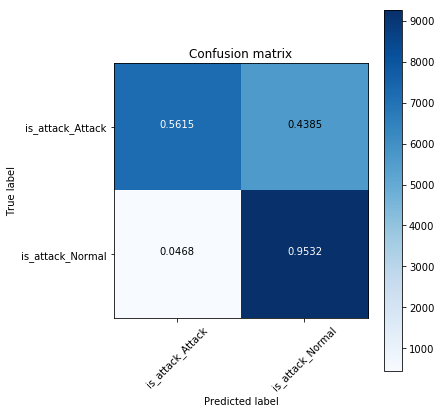

In [23]:
from sklearn.metrics import confusion_matrix
cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
plt.figure(figsize=[6,6])
plot_confusion_matrix(cm_2labels, output_columns_2labels, normalize = True)